In [319]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn

### Sample Image and Analysis

In [320]:
img=cv2.imread("../dataset/virat/v1.jpg")
img.shape

(605, 806, 3)

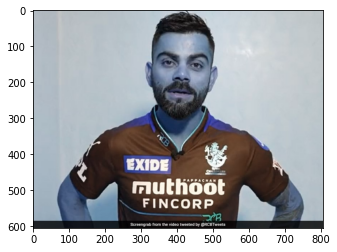

In [321]:
plt.imshow(img)

In [322]:
img_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray.shape

(605, 806)

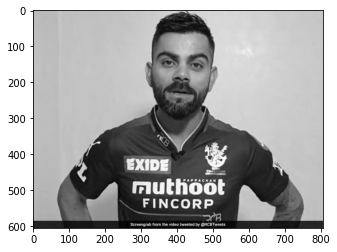

In [323]:
plt.imshow(img_gray,cmap='gray')

In [324]:
img_gray

array([[187, 187, 187, ..., 197, 197, 197],
       [187, 187, 187, ..., 197, 197, 197],
       [187, 187, 187, ..., 197, 197, 197],
       ...,
       [ 35,  35,  35, ...,  38,  38,  38],
       [ 35,  35,  35, ...,  38,  38,  38],
       [ 35,  35,  35, ...,  38,  38,  38]], dtype=uint8)

In [325]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
faces

array([[303,  58, 220, 220]])

In [326]:
(x,y,w,h)=faces[0]

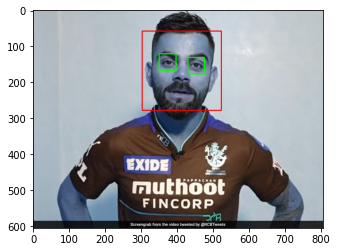

In [327]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
roi_gray = img_gray[y:y+h, x:x+w]
roi_color = face_img[y:y+h, x:x+w]
eyes = eye_cascade.detectMultiScale(roi_gray)
for (ex,ey,ew,eh) in eyes:
    cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.imshow(face_img, cmap='gray')

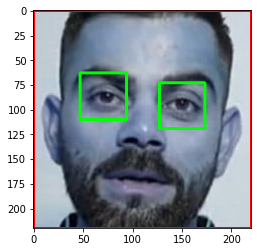

In [328]:
plt.imshow(roi_color, cmap='gray')

### Data Preprocessing

In [329]:
def only_face(image_path):
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = img_gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [313]:
path_to_data = "../dataset/"
path_to_cr_data = "../dataset/cropped/"

In [331]:
import os
img_dirs = []
for entry in os.scandir(path):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [332]:
img_dirs

['../dataset/abd',
 '../dataset/dhoni',
 '../dataset/sachin',
 '../dataset/starc',
 '../dataset/virat']

#### We are maiking a cropped directory which contains images of only faces

In [339]:
import shutil
if os.path.exists(path1):
     shutil.rmtree(path1)
os.mkdir(path1)

In [343]:
cropped_image_dirs = []
name_dict = {}

for img_dir in img_dirs:
    count = 1
    name = img_dir.split('/')[-1]
    print(name)
    
    name_dict[name] = []
    
    for entry in os.scandir(img_dir):
        try:
            roi_color = only_face(entry.path)
        except:
            continue
        if roi_color is not None:
            cropped_folder = path_to_cr_data + name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            name_dict[name].append(cropped_file_path)
            count += 1     

abd
dhoni
sachin
starc
virat


#### We have also done manual checking of cropped folder so that it doesn't contain image of some other person in same picture

### Wavlet Transform
#### We will use raw image stacked with wavlet image because wavlet image provides better description of edges etc.

In [377]:
# function for wavlet transform (taken from stackoverflow)
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    img = cv2.cvtColor( img,cv2.COLOR_RGB2GRAY )
    img =  np.float32(img)   
    img /= 255;
    coeffs=pywt.wavedec2(img, mode, level=level)
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  
    img_H=pywt.waverec2(coeffs_H, mode);
    img_H *= 255;
    img_H =  np.uint8(img_H)
    return img_H

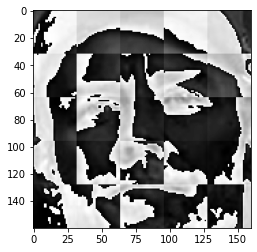

In [360]:
img_for_har=cv2.imread("../dataset/cropped/abd/abd3.png")
im_har = w2d(img_for_har,'db1',5)
plt.imshow(im_har, cmap='gray')

In [361]:
class_dict = {}
count = 0
for name in name_dict.keys():
    class_dict[name] = count
    count = count + 1
class_dict

{'abd': 0, 'dhoni': 1, 'sachin': 2, 'starc': 3, 'virat': 4}

In [368]:
X, y = [], []
for name, files in name_dict.items():
    for image in files:
        img = cv2.imread(image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[name]) 

In [374]:
print(len(X))
print(len(X[0]))

138
4096


In [371]:
len(y)

138

In [376]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(138, 4096)

### Training the Model

In [386]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6857142857142857

In [406]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       1.00      0.43      0.60         7
           2       0.83      0.56      0.67         9
           3       0.50      0.75      0.60         4
           4       0.67      1.00      0.80         8

    accuracy                           0.69        35
   macro avg       0.72      0.69      0.67        35
weighted avg       0.75      0.69      0.68        35



In [393]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#### We are using grid search for best model among svm,random forest, logistic regression

In [394]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [395]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    model = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(model, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.748571,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.583333,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.758571,{'logisticregression__C': 1}


In [399]:
print(best_estimators['svm'].score(X_test,y_test))
print(best_estimators['random_forest'].score(X_test,y_test))
print(best_estimators['logistic_regression'].score(X_test,y_test))

0.7428571428571429
0.42857142857142855
0.8


In [401]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,  best_estimators['svm'].predict(X_test))
cm

array([[6, 0, 0, 1, 0],
       [0, 4, 0, 1, 2],
       [0, 2, 6, 1, 0],
       [1, 0, 1, 2, 0],
       [0, 0, 0, 0, 8]], dtype=int64)

#### Confusion Matrix

{'abd': 0, 'dhoni': 1, 'sachin': 2, 'starc': 3, 'virat': 4}


Text(42.0, 0.5, 'Truth')

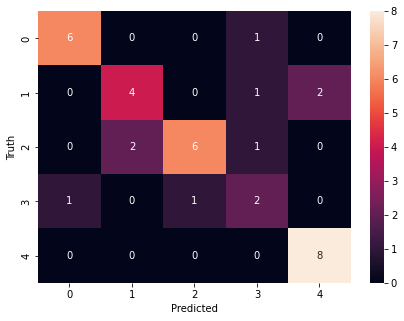

In [404]:
import seaborn as sn
print(class_dict)
plt.figure(figsize = (7,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')